In [1]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

import mimic
from mimic.utils import text as text
from mimic.utils.experiment import MimicExperiment
from mimic.utils.filehandling import get_config_path
from mimic.utils.flags import parser
from mimic.utils.flags import update_flags_with_config
from dataclasses import dataclass

[14:46:42 CET] Log file: /cluster/home/klugh/MIMIC/mimic/logger/logs/UTC-20210201-134642.log


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

FLAGS = parser.parse_args([])

config_path = get_config_path(FLAGS)

In [3]:
flags = update_flags_with_config(config_path, testing=True)

In [4]:
flags.modality = 'PA'
flags.img_size = 128
flags.text_encoding = 'word'
flags.feature_extractor_img = 'resnet'
flags.batch_size = 1
flags.dataloader_workers = 0
flags.device = device
flags.normalization = False
flags.len_sequence = 128
flags.str_experiment = 'something'
flags.alpha_modalities = [flags.div_weight_uniform_content, flags.div_weight_m1_content,
                          flags.div_weight_m2_content, flags.div_weight_m3_content]
flags.use_clf = False
flags.dir_gen_eval_fid = 'fdgb'

In [5]:
exp = MimicExperiment(flags)
exp.plot_img_size = torch.Size([1, flags.img_size, flags.img_size])
exp.modalities['text'].plot_img_size = torch.Size([1, flags.img_size+128, flags.img_size])
mods = exp.modalities

trainloader = DataLoader(exp.dataset_train, batch_size=flags.batch_size,
                         shuffle=False,
                         num_workers=flags.dataloader_workers, pin_memory=False)

nbr_samples = 5


[14:46:45 CET] setting dataset
[14:47:03 CET] setting modalities
[14:47:11 CET] setting clfs
[14:47:11 CET] setting rec_weights


In [6]:
def get_datas(which_label:int):
    datas = {'PA': [], 'Lateral': [], 'text': []}
    texts = []
    labels_list = []
    for data, labels in trainloader:
        if labels[0][which_label].item() == 1:
            for mod_key, mod in mods.items():
                datas[mod_key].append(mod.plot_data(exp, data[mod_key].squeeze(0)))
                if mod_key == 'text':
                    texts.append(data[mod_key])
                labels_list.append(labels[0].tolist())
            if len(datas[mod_key]) == nbr_samples:
                return datas, texts, labels_list

In [7]:
datas, texts, labels_list = get_datas(2)

In [8]:
rec = torch.Tensor()

for mod in mods:
    for idx in range(nbr_samples):
        if mod == 'text':
            img = datas[f'{mod}'][idx].cpu().unsqueeze(0)
        else:

            img = datas[f'{mod}'][idx].cpu()
            # pad the non text modalities such that they fit in a wider rectangle.
            m = nn.ZeroPad2d((64, 64, 0, 0))
            img = m(img.squeeze()).unsqueeze(0).unsqueeze(0)
        rec = torch.cat((rec, img), 0)

fig = mimic.utils.plot.create_fig(f'something.png',
                                  img_data=rec,
                                  num_img_row=nbr_samples, save_figure=False)

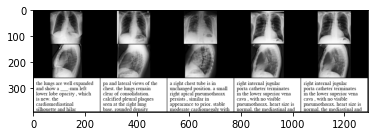

In [9]:
plt.imshow(fig)
plt.show()
plt.close()

the lungs are well expanded and show a ___-mm left lower lobe opacity , which is new .
 the cardiomediastinal silhouette and hilar contours are normal .
 no pleural effusion or pneumothorax is present .
 a moderate hiatal hernia is unchanged .
 <eos>
[1.0, 0.0, 1.0]


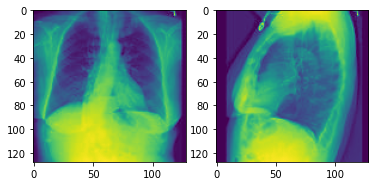

pa and lateral views of the chest .
 the lungs remain clear of consolidation .
 calcified pleural plaques seen at the right lung base .
 rounded density nodule projects over the left lung base on the frontal view .
 cardiomediastinal silhouette is within normal limits .
 no acute osseous abnormality detected .
 surgical clips seen in the left upper abdomen .
 <eos>
[1.0, 0.0, 1.0]


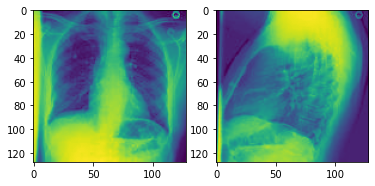

a right chest tube is in unchanged position .
 a small right apical pneumothorax persists , similar in appearance to prior .
 stable moderate cardiomegaly with improvement in pulmonary edema , now mild .
 a small right pleural effusion is present .
 <eos>
[1.0, 0.0, 1.0]


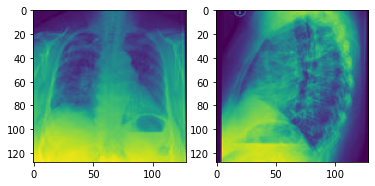

right internal jugular porta catheter terminates in the lower superior vena cava , with no visible pneumothorax .
 heart size is normal .
 the mediastinal and hilar contours are normal .
 the pulmonary vasculature is normal .
 lungs are clear .
 no pleural effusion or pneumothorax is seen .
 there are no acute osseous abnormalities .
 <eos>
[0.0, 0.0, 1.0]


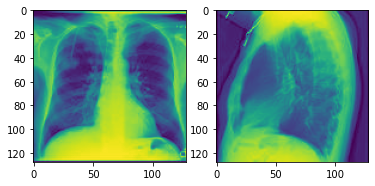

right internal jugular porta catheter terminates in the lower superior vena cava , with no visible pneumothorax .
 heart size is normal .
 the mediastinal and hilar contours are normal .
 the pulmonary vasculature is normal .
 lungs are clear .
 no pleural effusion or pneumothorax is seen .
 there are no acute osseous abnormalities .
 <eos>
[0.0, 0.0, 1.0]


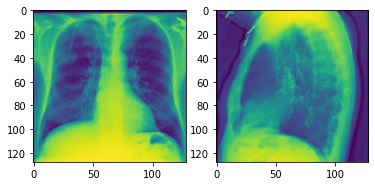

In [10]:
for i in range(nbr_samples):
    text_sample = text.tensor_to_text(exp, texts[i], one_hot=False)[0]
    text_sample = [word for word in text_sample if word != '<pad>']
    print(' '.join(text_sample).replace('.', '.\n'))
    print(labels_list[i])
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(datas['PA'][i].squeeze())
    plt.subplot(1, 2, 2)
    plt.imshow(datas['Lateral'][i].squeeze())
    plt.show()
    plt.close()

# Lung Opacity

In [11]:
datas, texts, labels_list = get_datas(0)

the heart is normal in size .
 the mediastinal and hilar contours appear within normal limits .
 each hilum is mildly prominent , probably suggesting mild prominence of central pulmonary vessels , but there is no frank congestive heart failure .
 no focal opacification is seen aside from streaky left lower lung opacity suggesting minor atelectasis .
 there is no pleural effusion or pneumothorax .
 bony structures are unremarkable .
 <eos>
[1.0, 0.0, 0.0]


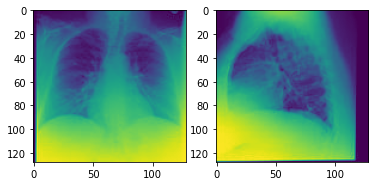

pa and lateral views of the chest are provided .
 suture material is again noted in the right mid lung .
 scattered ill-defined opacities in this patient with history of sarcoid could represent air or superimposed infection .
 overall pattern is similar to prior exam from ___ .
 no large effusion or pneumothorax .
 deformity of the lower thoracic spine on the lateral view is noted .
 otherwise , the bony structures are intact .
 <eos>
[1.0, 0.0, 0.0]


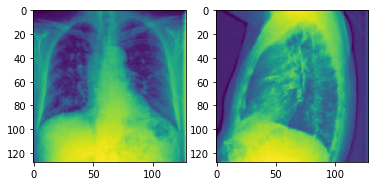

cardiac , mediastinal and hilar contours are normal .
 pulmonary vasculature is normal .
 streaky left lower lobe opacity is present along with a small left pleural effusion .
 right lung is clear .
 no pneumothorax is identified .
 no acute osseous abnormality is detected .
 <eos>
[1.0, 0.0, 0.0]


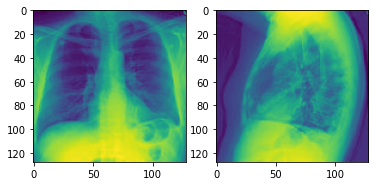

pa and lateral images of the chest .
 there has been interval development of bibasilar opacities , which are concerning for a <exc> developing pneumonia versus alveolar hemorrhage .
 there appears to be a small left pleural effusion .
 there is no right pleural effusion or pneumothorax .
 the cardiomediastinal silhouette is unremarkable .
 <eos>
[1.0, 0.0, 0.0]


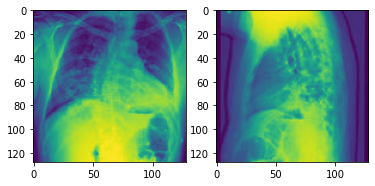

pa and lateral views of the chest demonstrate the lungs are well expanded .
 two adjacent nodular opacities project along the upper aspect of the left ventricle on the lateral view .
 the cardiomediastinal silhouette is otherwise unremarkable .
 there is no evidence of pleural effusion or focal pneumonia .
 azygous vein distension is present , with no evidence of left heart failure .
 no pneumothorax is identified .
 <eos>
[1.0, 0.0, 0.0]


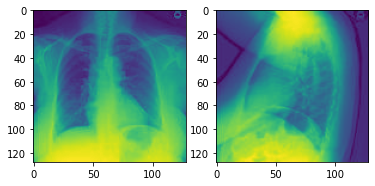

In [12]:
for i in range(nbr_samples):
    text_sample = text.tensor_to_text(exp, texts[i], one_hot=False)[0]
    text_sample = [word for word in text_sample if word != '<pad>']
    print(' '.join(text_sample).replace('.', '.\n'))
    print(labels_list[i])
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(datas['PA'][i].squeeze())
    plt.subplot(1, 2, 2)
    plt.imshow(datas['Lateral'][i].squeeze())
    plt.show()
    plt.close()

# Pleural Effusion

In [13]:
datas, texts, labels_list = get_datas(1)

heart size remains mild to moderately enlarged .
 the aorta is tortuous and diffusely calcified .
 mediastinal and hilar contours are otherwise unchanged .
 previous pattern of mild pulmonary edema has essentially resolved .
 mild atelectasis is seen in the lung bases without focal consolidation .
 blunting of the costophrenic angles bilaterally suggests trace bilateral pleural effusions , not substantially changed in the interval .
 no pneumothorax is present .
 <eos>
[0.0, 1.0, 0.0]


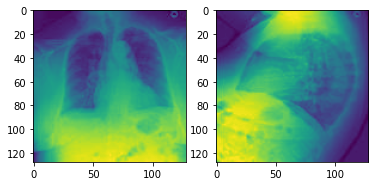

pa and lateral views of the chest demonstrate low lung volumes .
 tiny bilateral pleural effusions are new since ___ .
 no signs of pneumonia or pulmonary vascular congestion .
 heart is top normal in size though this is stable .
 aorta is markedly tortuous , unchanged .
 aortic arch calcifications are seen .
 there is no pneumothorax .
 no focal consolidation .
 partially imaged upper abdomen is unremarkable .
 <eos>
[0.0, 1.0, 0.0]


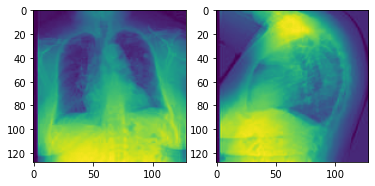

lung volumes are normal .
 small to moderate bilateral pleural effusions are unchanged since yesterday .
 left retrocardiac opacity likely reflects atelectasis .
 there is no new worrisome pulmonary opacity .
 mild cardiomegaly is unchanged .
 as before the main pulmonary artery is enlarged .
 there is no pneumothorax .
 <eos>
[0.0, 1.0, 0.0]


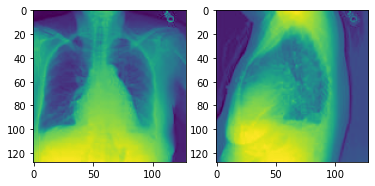

no significant interval change .
 bilateral small pleural effusions and adjacent atelectasis are overall unchanged .
 the heart is top-normal in size , unchanged .
 the pulmonary artery is enlarged , suggesting pulmonary hypertension .
 no <exc> , focal consolidation to suggest pneumonia , or pneumothorax .
 <eos>
[0.0, 1.0, 0.0]


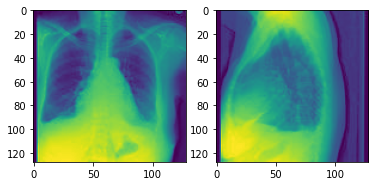

cardiac , mediastinal and hilar contours are normal .
 pulmonary vasculature is normal .
 streaky left lower lobe opacity is present along with a small left pleural effusion .
 right lung is clear .
 no pneumothorax is identified .
 no acute osseous abnormality is detected .
 <eos>
[0.0, 1.0, 0.0]


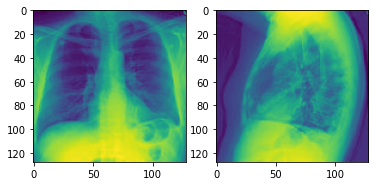

In [14]:
for i in range(nbr_samples):
    text_sample = text.tensor_to_text(exp, texts[i], one_hot=False)[0]
    text_sample = [word for word in text_sample if word != '<pad>']
    print(' '.join(text_sample).replace('.', '.\n'))
    print(labels_list[i])
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(datas['PA'][i].squeeze())
    plt.subplot(1, 2, 2)
    plt.imshow(datas['Lateral'][i].squeeze())
    plt.show()
    plt.close()

# Experiments with the torch.WeightedRandomSampler

## Without sampling

In [15]:
trainloader = DataLoader(exp.dataset_train, batch_size=50,
                         shuffle=False,
                         num_workers=flags.dataloader_workers, pin_memory=False)

In [16]:
all_labels = torch.Tensor()
for _, labels in trainloader:
    all_labels = torch.cat((all_labels, labels.cpu()), 0)

In [17]:
print(all_labels.shape)

torch.Size([60461, 3])


In [18]:
{label: all_labels[:, i].sum() for i, label in enumerate(['Lung Opacity', 'Pleural Effusion', 'Support Devices'])}

{'Lung Opacity': tensor(6775.),
 'Pleural Effusion': tensor(3609.),
 'Support Devices': tensor(906.)}

### With sampling

In [19]:
def calculateWeights(label_dict, d_set):
    arr = []
    for label, count in label_dict.items():
        weight = count / len(d_set)
        arr.append(weight)
    return arr

In [20]:
labels_df = exp.dataset_train.labels
counts = labels_df[labels_df == 1].count()

In [21]:
print(counts)

Lung Opacity        6775
Pleural Effusion    3609
Support Devices      906
dtype: int64


In [22]:
weights = calculateWeights(counts, exp.dataset_train)
weights = torch.DoubleTensor(weights)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(exp.dataset_train), replacement=True)

In [23]:
trainloader = DataLoader(exp.dataset_train, batch_size=50, sampler=sampler,
                         shuffle=False,
                         num_workers=flags.dataloader_workers, pin_memory=False)

In [24]:
all_labels = torch.Tensor()
for _, labels in trainloader:
    all_labels = torch.cat((all_labels, labels.cpu()), 0)

In [25]:
print(all_labels.shape)

torch.Size([60461, 3])


In [26]:
{label: all_labels[:, i].sum() for i, label in enumerate(['Lung Opacity', 'Pleural Effusion', 'Support Devices'])}




{'Lung Opacity': tensor(0.),
 'Pleural Effusion': tensor(0.),
 'Support Devices': tensor(0.)}